In [ ]:
from trackml.dataset import load_event
from trackml.utils import add_position_quantities, add_momentum_quantities, decode_particle_id

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

path = '/nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/'
event = 'event000001000'

print('Loading event {}'.format(path+event))

hits, cells, particles, truth = load_event(path+event)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event, mem_bytes / 2**20))

In [ ]:
'''
Representación de los hits
'''
print(hits.head())

g = sns.jointplot(x=hits.x, y=hits.y, s=1, height=6)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()
# # Iterar sobre los volúmenes únicos
# for volume in hits['volume_id'].unique():  
#     fig = plt.figure(figsize=(12, 8))
#     ax = fig.add_subplot(111, projection='3d')
#     hits_volume = hits[hits['volume_id'] == volume]  # Filtrar los hits por volumen
#     ax.scatter(hits_volume['x'], hits_volume['y'], hits_volume['z'], 
#                label=f'Volume {volume}', s=5, alpha=0.75)

# ax.legend()
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Distribución de hits por volumen')
# plt.show()

Dimensión dataset hits:   (120939, 7)
=========== Hits centrales ===========
       hit_id          x          y           z  volume_id  layer_id  \
16873   16874 -32.554401  -3.648710 -469.864990          8         2   
16874   16875 -33.153702  -1.934740 -423.516998          8         2   
16875   16876 -26.362400 -18.423700 -461.375000          8         2   
16876   16877 -12.034100 -29.649799 -464.428009          8         2   
16877   16878 -15.127200 -28.159300 -439.713989          8         2   

       module_id  
16873          1  
16874          1  
16875          2  
16876          3  
16877          3  
(29172, 7)
Tomamos solo un 24.1213% de los hits
Tengo un total de 1085 módulos
Tengo un total de 4 capas
Mis capas son: [2 4 6 8]
Data.shape() = (29172, 3)
Numero de hits en la primera capa: 8892
Data.shape() = (8892, 3)
Data.shape() = (1000, 3)
Dimensión de smoothed_positions: (50, 3, 1)
Dimensión de smoothed_positions: (50, 3, 1)
Dimensión de smoothed_positions: (100, 3, 

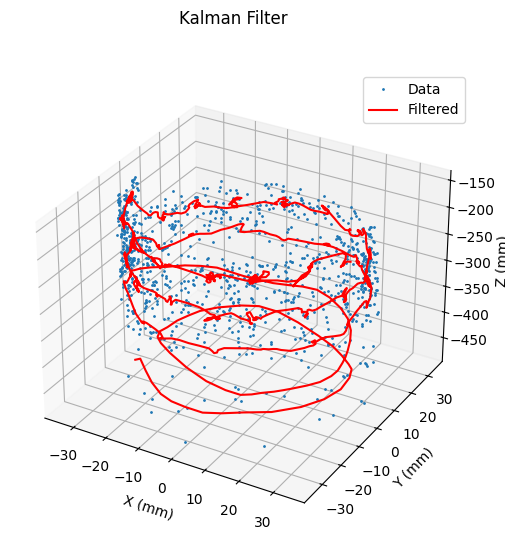

In [5]:
import importlib
import kalman_filter
importlib.reload(kalman_filter)
from kalman_filter import KalmanFilter
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#print(hits.head())
print("Dimensión dataset hits:  ", hits.shape)
'''
Voy a querer elegir primero solo los hits centrales, es decir, los del volumen 8
'''

print("=========== Hits centrales ===========")
hits_centrales = hits[hits.volume_id == 8]
print(hits_centrales.head())
print(hits_centrales.shape)

print("Tomamos solo un {:.4f}% de los hits".format(hits_centrales.shape[0]/hits.shape[0]*100))

print(f"Tengo un total de {hits_centrales.module_id.nunique()} módulos")
print(f"Tengo un total de {hits_centrales.layer_id.nunique()} capas")
print(f"Mis capas son: {hits_centrales.layer_id.unique()}")

data = hits_centrales[['x', 'y', 'z']].values
#print(data)
print(f"Data.shape() = {data.shape}")

# Número de hits en la primera capa
print(f"Numero de hits en la primera capa: {hits_centrales[hits_centrales.layer_id == 2].shape[0]}")

# Tomemos solo los hits en la primera capa
data = hits_centrales[hits_centrales.layer_id == 2][['x', 'y', 'z']].values
print(f"Data.shape() = {data.shape}")

data = data[:1000]
print(f"Data.shape() = {data.shape}")

'''
plt.plot(data[:,0], 'o', label='X', markersize=.3)
plt.xlabel('Hit')
plt.ylabel('X (mm)')
plt.show()
'''
'''
Tengo que calcular x0 como trayectoria inicial entre un par de hits. 
'''

i = 1
hit_1 = hits_centrales[hits_centrales.module_id == i].iloc[0]
hit_2 = hits_centrales[hits_centrales.module_id == i+1].iloc[0]   

#hit_1 = hits_centrales.iloc[0]
#hit_2 = hits_centrales.iloc[1]

x1, y1, z1 = hit_1['x'], hit_1['y'], hit_1['z']
x2, y2, z2 = hit_2['x'], hit_2['y'], hit_2['z']

dt = 1.0

slope_x = (x2 - x1) / 1.0
slope_y = (y2 - y1) / 1.0
slope_z = (z2 - z1) / 1.0

#x0 = np.array([data[0,0], 0, data[0,1], 0, data[0,2], 0])
x0 = np.array([x1, slope_x, y1, slope_y, z1, slope_z]).reshape(-1, 1)
#print(x0)

dim_data = data.shape[1]

F = np.array([[1, dt, 0,  0,  0,  0],
              [0,  1,  0,  0,  0,  0],
              [0,  0,  1, dt,  0,  0],
              [0,  0,  0,  1,  0,  0],
              [0,  0,  0,  0,  1, dt],
              [0,  0,  0,  0,  0,  1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0]])

C = np.eye(6) * 1e-3
Q = np.eye(6) * 0.1
R = np.eye(3) * 0.3

kf = KalmanFilter(C = C, F = F, 
                  H = H, Q = Q, R = R, x0 = x0)

trajectory = []
for i in range(int(len(data))):
    m = data[i]
    kf.predict()
    kf.update(m)
    kf.smoothing_RTS()
    smoothed_states, smoothed_positions = kf.smoothing_RTS()
    #trajectory.append(smoothed_positions)
    #trajectory.append(kf.x[[0, 2, 4]].flatten())


# Convertir a DataFrame, las posiciones x, y, z
#smoothed_df = pd.DataFrame(smoothed_positions[:, :, 0], columns=["x", "y", "z"])

# Eliminar la dimensión extra (dimensión de tamaño 1)
smoothed_positions = smoothed_positions.squeeze(axis=-1)
smoothed_df = pd.DataFrame(smoothed_positions, columns=["x", "y", "z"])


#with open('smoothed_df.txt', 'w') as f:
#    f.write(smoothed_df.to_string())

trajectory = smoothed_states
print(f"trajectory.shape = {trajectory.shape}")

print("\n=========== Smoothed_df ===========")
print(smoothed_df.head())


fig = plt.figure(figsize=(6, 6))
fig.suptitle('Kalman Filter')

ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:,0], data[:,1], data[:,2], 'o', label='Data', markersize=1)
ax.plot(trajectory[:,0], trajectory[:,2], trajectory[:,4], label='Filtered', color='red')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
plt.legend()
plt.show()

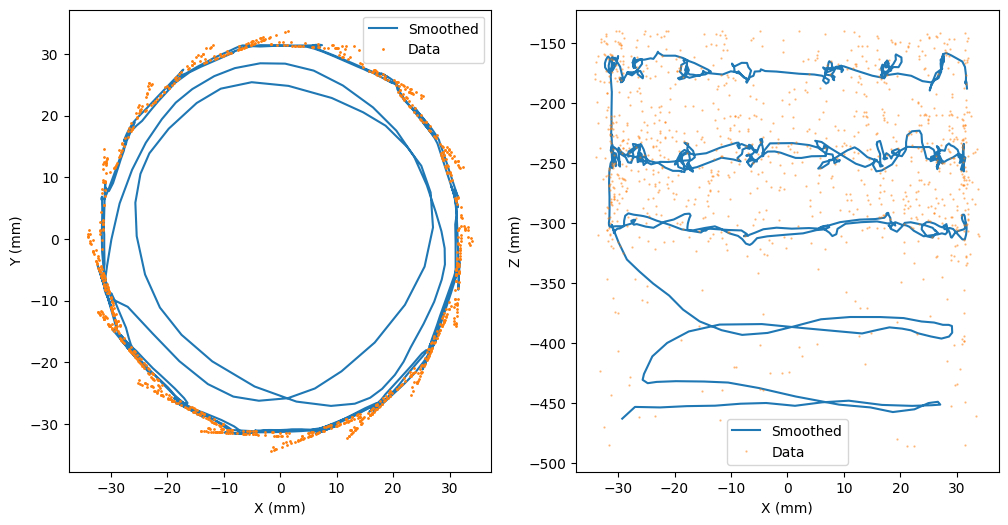

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(smoothed_df['x'], smoothed_df['y'], '-', label='Smoothed', markersize=.6)
plt.plot(data[:,0], data[:,1], 'o', label='Data', markersize=1)
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(smoothed_df['x'], smoothed_df['z'], '-', label='Smoothed', markersize=.6)
plt.plot(data[:,0], data[:,2], 'o', label='Data', markersize=.6, alpha=0.5)
plt.xlabel('X (mm)')
plt.ylabel('Z (mm)')
plt.legend()

plt.show()

1. Seleccionar pares de hits prometedores. 50 pares de hits entre capas adyacentes.

        particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   

          pz  q  nhits         r      phi     theta  
0  -0.203492 -1      8  0.079048  2.32629  2.969372  
1   2.010060  1     11  0.079048  2.32629  2.969372  
2   0.683881 -1      0  0.079048  2.32629  2.969372  
3   0.991616  1     12  0.079048  2.32629  2.969372  
4 -39.824902  1      3  0.079048  2.32629  2.969372  


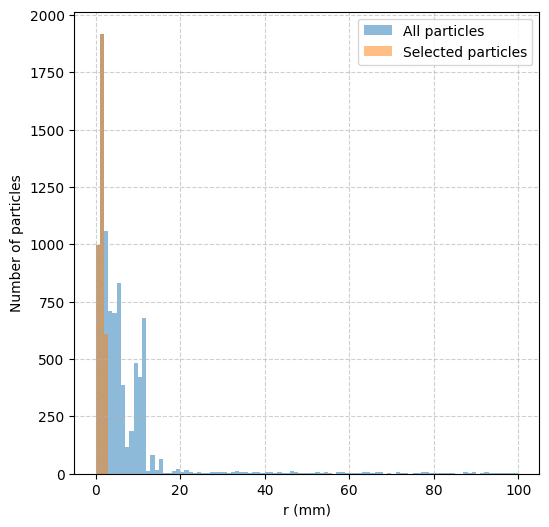

    hit_id          x         y       z  volume_id  layer_id  module_id
1        2 -55.336102  0.635342 -1502.5          7         2          1
9       10 -90.292900 -3.269370 -1502.5          7         2          1
10      11 -59.182999 -0.670508 -1502.5          7         2          1
12      13 -72.533997  2.642190 -1502.5          7         2          1
14      15 -63.436501 -3.262220 -1502.5          7         2          1
Los datos que tomo son un 29.4380% de los datos originales


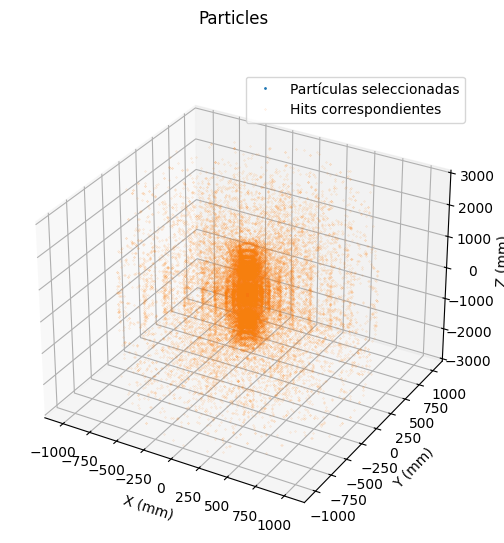

In [ ]:
def distance(particle):
    ''' Distancia en mm de la partícula al origen'''
    return np.sqrt(particle.vx**2 + particle.vy**2 + particle.vz**2)

particles['r'] = distance(particles)
particles['phi'] = np.arctan2(particles.vy, particles.vx)
particles['theta'] = np.arccos(particles.vz / particles.r)

print(particles.head())

# Voy a coger solo las partículas con r < 2.6
particles_all = particles
particles = particles[particles.r < 2.6]

# Con ese radio, voy a coger solo las partículas con z entre -25 y 25 mm
particles = particles[(particles.vz > -25) & (particles.vz < 25)]

# Histograma normalizado a 1 de la variable r
plt.figure(figsize=(6, 6))
plt.hist(particles_all.r, bins=100, range=(0, 100), density=False, alpha=0.5, label='All particles')
plt.hist(particles.r, bins=100, range=(0, 100), density=False, alpha=0.5, label='Selected particles')
plt.legend()
plt.xlabel('r (mm)')    
plt.ylabel('Number of particles')
plt.grid(linestyle='--', alpha=0.6)
plt.show()

# Del truth cojo solo las partículas que están en particles
truth = truth[truth.particle_id.isin(particles.particle_id)]

# Cojo ahora los hits_id que están en truth
hits_all = hits
hits = hits[hits.hit_id.isin(truth.hit_id)]
print(hits.head())

print("Los datos que tomo son un {:.4f}% de los datos originales".format(hits.shape[0]/hits_all.shape[0]*100))


# Represento el dataset de particles en 3D
fig = plt.figure(figsize=(6, 6))
plt.suptitle('Particles')
ax = fig.add_subplot(111, projection='3d')
ax.plot(particles.vx, particles.vy, particles.vz, 'o', markersize=1, label = 'Partículas seleccionadas')
#ax.plot(particles_all.vx, particles_all.vy, particles_all.vz, 'x', alpha  = .6, markersize = .6, label = 'Todas las partículas')
ax.plot(hits.x, hits.y, hits.z, 'o', markersize=.2, alpha= .4, label = 'Hits correspondientes')
ax.legend(loc = 'best')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from kalman_filter import KalmanFilter  # Asegúrate que tu clase esté bien definida

### ======== Matrices de covarianza ========
F = np.array([[1, dt, 0,  0,  0,  0],
              [0,  1,  0,  0,  0,  0],
              [0,  0,  1, dt,  0,  0],
              [0,  0,  0,  1,  0,  0],
              [0,  0,  0,  0,  1, dt],
              [0,  0, 0,  0,  0,  1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0]])

C = np.eye(6) * 1e-2
Q = np.eye(6) * 0.3
R = np.eye(3) * 0.3

# ======== Funciones de procesamiento ========
def cos_angle(v1, v2):
    ''' Calcula el coseno del ángulo entre dos vectores '''
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def reduce_hits(hits, fraction=.2):
    ''' Reduce el número de hits '''
    return hits.sample(frac=fraction, random_state=42)

# ======== Datos de entrada ========
volume_ids = hits['volume_id'].unique()
#volume_ids = [volume_ids[1], volume_ids[4], volume_ids[7]]
first_volume = volume_ids[0]  # Solo usamos el primer volumen para x0

hits_dict_all_volumes = {}  # Diccionario por volúmenes

for volume_id in volume_ids:
    hits_volume = hits[hits.volume_id == volume_id].copy()
    hits_volume['r'] = np.sqrt(hits_volume.x**2 + hits_volume.y**2 + hits_volume.z**2)
    layers = hits_volume['layer_id'].unique()
    
    hits_dict = {}
    for layer in layers:
        hits_layer = hits_volume[hits_volume.layer_id == layer]
        hits_reduced = reduce_hits(hits_layer)
        hits_dict[layer] = hits_reduced
    
    hits_dict_all_volumes[volume_id] = hits_dict

print(f"Procesando primer volumen ({first_volume}) para obtener x0")

# ======== Selección de x0 ========
layers_sorted = sorted(hits_dict_all_volumes[first_volume].keys())

first_layer = layers_sorted[0]   # Primera capa
second_layer = layers_sorted[1]  # Segunda capa

vertex = np.array([0, 0, 0])
tracks = []

for i in tqdm(range(len(hits_dict_all_volumes[first_volume][first_layer])), desc=f"Procesando trayectorias desde volumen {first_volume}"):
    hit1_pos = hits_dict_all_volumes[first_volume][first_layer].iloc[i][['x', 'y', 'z']].values  
    v1 = hit1_pos - vertex  

    for j in range(len(hits_dict_all_volumes[first_volume][second_layer])):  
        hit2_pos = hits_dict_all_volumes[first_volume][second_layer].iloc[j][['x', 'y', 'z']].values  
        v2 = hit2_pos - hit1_pos

        cos_value = cos_angle(v1, v2)
        if abs(cos_value) > 0.9:
            slope = v2  
            x0 = np.array([v1[0], slope[0], v1[1], slope[1], v1[2], slope[2]]).reshape(-1, 1)

            # ======== Inicialización del Filtro de Kalman ========
            kf = KalmanFilter(C=C, F=F, H=H, Q=Q, R=R, x0=x0)
            # No me hace falta predecir la segunda posición o sí?
            #kf.predict()
            #kf.update(hit2_pos)

            # ======== Propagación en todos los volúmenes ========
            for volume_id in volume_ids:    # Selecciono el volumen 
                for layer in sorted(hits_dict_all_volumes[volume_id].keys()):   # E itero sobre las capas del volumen
                    hits_layer = hits_dict_all_volumes[volume_id][layer]  
                    hits_layer_np = hits_layer[['x', 'y', 'z']].values

                    kf.predict()
                    pred_pos = kf.x[[0, 2, 4]].flatten()  
                    distances_layer = np.linalg.norm(hits_layer_np - pred_pos, axis=1)  
                    best_hit = hits_layer_np[np.argmin(distances_layer)]  
                    kf.update(best_hit)  

            # ======== Aplicar smoothing y guardar trayectoria ========
            _, smoothed_positions = kf.smoothing_RTS()
            tracks.append(smoothed_positions.squeeze())  

            break  # Primer hit2 que encaja

# ======== Visualización ========
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Mostrar todos los hits de todos los volúmenes
for volume_id in volume_ids:
    for layer in hits_dict_all_volumes[volume_id].keys():  
        layer_hits = hits_dict_all_volumes[volume_id][layer]
        ax.scatter(layer_hits['x'], layer_hits['y'], layer_hits['z'], 
                   label=f'Volume {volume_id}: Layer {layer}', s=3, alpha=0.5)

# Dibujar trayectorias suavizadas
for track in tracks[:50]:  
    ax.plot(track[:, 0], track[:, 1], track[:, 2], color='tab:red', alpha=1, linewidth=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Trayectorias suavizadas con Kalman RTS')
plt.show()

print(f"Total de tracks encontrados y suavizados: {len(tracks)}")


Procesando primer volumen (7) para obtener x0


Procesando trayectorias desde volumen 7: 100%|██████████| 92/92 [00:02<00:00, 39.81it/s]


Total de tracks encontrados y suavizados: 92


In [69]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Definir función para calcular la distancia entre la línea que pasa por dos hits y el origen
def distance_from_origin(hit1, hit2):
    direction = hit2 - hit1
    origin_distance = np.linalg.norm(np.cross(hit1, direction)) / np.linalg.norm(direction)
    return origin_distance

# Definir la función para calcular el ángulo entre dos vectores
def angle_between_vectors(v1, v2):
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(np.clip(cos_angle, -1.0, 1.0))  # Para evitar valores fuera de rango

def pair_is_good(pair):
    ''' Consideraciones de si un para es bueno o no en función de la distancia y ángulo '''
    origin_dist, angle = pair
    # Definir una regla arbitraria: por ejemplo, que el par sea "bueno" si la distancia es pequeña y el ángulo es cercano a 0
    if origin_dist < 5 and angle < np.arccos(0.5):
        return True
    return False


#print(f"hits_dict_all_volumes: {hits_dict_all_volumes}")

n_volumes = 3  # Número de volúmenes que deseas procesar
limited_volumes = list(hits_dict_all_volumes.items())[:n_volumes]

pairs = []
for volume_id, volume_hits in limited_volumes:
    print(f"Processing volume {volume_id}")
    
    # Ordenar las claves de las capas (si no son consecutivas, esto las organizará correctamente)
    sorted_layers = sorted(volume_hits.keys())
    
    # Iterar sobre las capas y emparejarlas con la siguiente capa disponible
    for i in range(len(sorted_layers) - 1):  # Excluimos la última capa porque no tiene siguiente   
        layer = sorted_layers[i]
        next_layer = sorted_layers[i + 1]
        
        print(f"Processing layer {layer} and next layer {next_layer} in volume {volume_id}")
        
        # Obtener los hits de la capa actual y la siguiente
        layer_hits = volume_hits[layer]
        next_layer_hits = volume_hits[next_layer]
        
        # Verificar si hay hits en ambas capas
        if len(layer_hits) == 0 or len(next_layer_hits) == 0:
            print(f"No hits in one of the layers {layer} or {next_layer} for volume {volume_id}")
            continue
        
        # Generar pares de hits entre las capas adyacentes
        for hit1 in layer_hits.itertuples():
            for hit2 in next_layer_hits.itertuples():
                # Convertir los hits a arrays numpy (necesarios para las funciones matemáticas)
                hit1_pos = np.array([hit1.x, hit1.y, hit1.z])
                hit2_pos = np.array([hit2.x, hit2.y, hit2.z])
                
                # Calcular la distancia desde el origen y el ángulo entre los hits
                origin_dist = distance_from_origin(hit1_pos, hit2_pos)
                angle = angle_between_vectors(hit1_pos, hit2_pos)
                
                # Guardar el par de hits con sus características
                pairs.append([origin_dist, angle])  # Solo las características, no los hits

#print(hits_dict_all_volumes)

# Verificar si realmente se generaron pares
print(f"Total pairs generated: {len(pairs)}")
if len(pairs) == 0:
    print("No pairs were generated. Check your data.")

# Convertir a un formato adecuado para regresión logística
X_pairs = np.array([pair for pair in pairs])  # Características: distancia y ángulo
y_pairs = np.array([1 if pair_is_good(pair) else 0 for pair in pairs])  # Etiquetas (1: buen par, 0: mal par)

# Verificar la forma de X_pairs y y_pairs
print(f"X_pairs.shape: {X_pairs.shape}")
print(f"y_pairs.shape: {y_pairs.shape}")

# Asegurarse de que X_pairs y y_pairs no están vacíos y tienen la forma adecuada
if X_pairs.shape[0] > 0 and X_pairs.shape[1] == 2 and y_pairs.shape[0] == X_pairs.shape[0]:
    # Regresión logística para hacer pruning
    clf = LogisticRegression(max_iter=1000)  # Asegúrate de que el modelo converge
    clf.fit(X_pairs, y_pairs)

    # Filtrar los pares usando el modelo entrenado
    promising_pairs = [pair for pair, score in zip(pairs, clf.predict_proba(X_pairs)[:, 1]) if score > 0.9]
else:
    print("Los datos de entrada no tienen la forma adecuada para el modelo.")



Processing volume 7
Processing layer 2 and next layer 4 in volume 7
Processing layer 4 and next layer 6 in volume 7
Processing layer 6 and next layer 8 in volume 7
Processing layer 8 and next layer 10 in volume 7
Processing layer 10 and next layer 12 in volume 7
Processing layer 12 and next layer 14 in volume 7
Processing volume 8
Processing layer 2 and next layer 4 in volume 8
Processing layer 4 and next layer 6 in volume 8
Processing layer 6 and next layer 8 in volume 8
Processing volume 9
Processing layer 2 and next layer 4 in volume 9
Processing layer 4 and next layer 6 in volume 9
Processing layer 6 and next layer 8 in volume 9
Processing layer 8 and next layer 10 in volume 9
Processing layer 10 and next layer 12 in volume 9
Processing layer 12 and next layer 14 in volume 9
Total pairs generated: 1110478
X_pairs.shape: (1110478, 2)
y_pairs.shape: (1110478,)
